We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Defining the geometry of the powderbed:

In [2]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1.54e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0.0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [4]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

defining the pde system:

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    molten = T > 1693
    
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = tf.where(molten, k, 0.6*k)
    rho_eff = tf.where(molten, rho, 0.6*rho)
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [6]:
def top_bc(X, Y):
    
    molten = Y > 1693
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff =  k_eff = tf.where(molten, k, 0.6*k)
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/20))

creating the dataset:

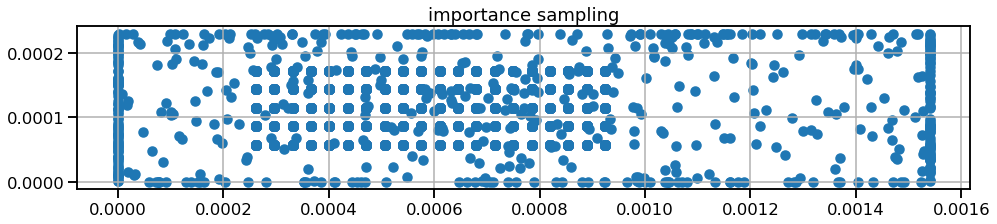

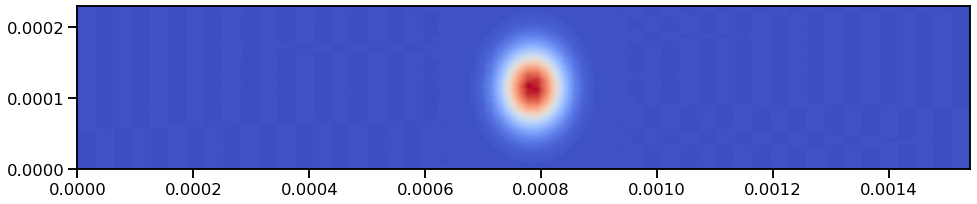

In [7]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.17*x_max, 0.6*x_max, 20)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 5)
z_lin = np.linspace(0.5*z_max, z_max, 10)
t_lin = np.linspace(0, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, z_lin, t_lin)
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 500,
                       train_distribution="pseudo",
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (16, 3))
plt.scatter(points[0], points[1])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()

def top_bc_test(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
plot_data = griddata((np.ravel(xx), np.ravel(yy)), top_bc_test(X)[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, plot_data, 100, cmap=plt.cm.coolwarm)
#plt.colorbar()

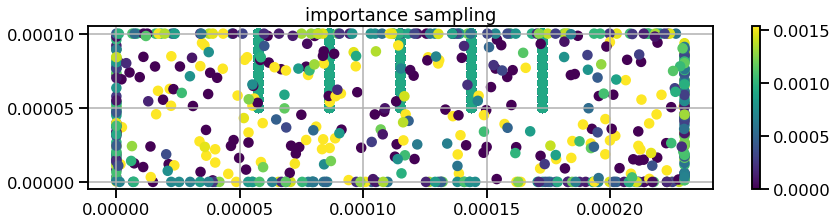

In [8]:
plt.figure(figsize = (14, 3))
plt.scatter(points[1], points[2], c = points[0])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [9]:
#net = dde.nn.FNN([4] + [50] * 8 + [1], "sin", "Glorot normal")
# activation = f"LAAF-{5} sin" 
net = dde.nn.MsFFN([4] + [50] * 6 + [1], "sin", "Glorot normal", sigmas = [1, 0.1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + Temperature*2000e1*t#*t*x*y*z#*(x - x_max)*(y-y_max) + 20.0 + T_0
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-07-03 10:31:05.644841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 10:31:05.772911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 10:31:05.773993: I tensorflow/stream_execu

'compile' took 3.986163 s



In [10]:
losshistory, train_state = model.train(epochs=0, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1])
resampler = dde.callbacks.PDEResidualResampler(100)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.94e+08, 3.89e+15, 1.63e+02]    [6.94e+08, 3.89e+15, 1.63e+02]    []  

Best model at step 0:
  train loss: 3.89e+15
  test loss: 3.89e+15
  test metric: []

'train' took 1.364830 s



In [11]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e4, 1e3])
model.compile('adam',lr = 1e-3, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 3.005303 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.68e-01, 9.81e+03, 6.20e+02]    [1.68e-01, 9.81e+03, 6.20e+02]    []  
100       [1.18e+02, 8.08e+03, 1.09e+02]    [1.18e+02, 8.08e+03, 1.09e+02]    []  
200       [8.31e+01, 6.20e+03, 1.63e+01]    [8.05e+01, 6.20e+03, 1.63e+01]    []  
300       [9.11e+01, 5.60e+03, 1.32e+01]    [9.09e+01, 5.60e+03, 1.32e+01]    []  
400       [9.32e+01, 5.34e+03, 9.23e+00]    [9.38e+01, 5.34e+03, 9.23e+00]    []  
500       [1.04e+02, 5.26e+03, 1.44e+01]    [1.06e+02, 5.26e+03, 1.44e+01]    []  
600       [1.21e+02, 4.89e+03, 6.57e+00]    [1.14e+02, 4.89e+03, 6.57e+00]    []  
700       [1.61e+02, 4.70e+03, 1.38e+01]    [1.63e+02, 4.70e+03, 1.38e+01]    []  
800       [1.13e+02, 4.56e+03, 6.35e+00]    [1.17e+02, 4.56e+03, 6.35e+00]    []  
900       [1.09e+02, 4.39e+03, 1.11e+01]    [1.10e+02, 4.39e+03, 1.11e+0

In [15]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e4, 1e3])
model.compile('adam',lr = 2e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 2.926271 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [1.04e+02, 3.03e+03, 3.55e+00]    [1.01e+02, 3.03e+03, 3.55e+00]    []  
2100      [1.04e+02, 2.86e+03, 3.31e+00]    [1.03e+02, 2.86e+03, 3.31e+00]    []  
2200      [1.33e+02, 2.67e+03, 3.66e+00]    [1.32e+02, 2.67e+03, 3.66e+00]    []  
2300      [1.40e+02, 2.51e+03, 4.04e+00]    [1.27e+02, 2.51e+03, 4.04e+00]    []  
2400      [2.69e+02, 2.32e+03, 5.11e+00]    [2.62e+02, 2.32e+03, 5.11e+00]    []  
2500      [2.44e+02, 2.22e+03, 6.01e+00]    [2.42e+02, 2.22e+03, 6.01e+00]    []  
2600      [1.66e+02, 2.07e+03, 6.47e+00]    [1.66e+02, 2.07e+03, 6.47e+00]    []  
2700      [1.50e+02, 1.97e+03, 6.46e+00]    [1.39e+02, 1.97e+03, 6.46e+00]    []  
2800      [1.16e+02, 1.94e+03, 6.70e+00]    [1.16e+02, 1.94e+03, 6.70e+00]    []  
2900      [1.60e+02, 1.81e+03, 6.60e+00]    [1.59e+02, 1.81e+03, 6.60e+00]    []  
3000      [2.07

In [19]:
weights_2 = np.array([1, 1e4, 1e3])
model.compile('adam',lr = 1e-5, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 20000, display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 3.377805 s

Training model...

Step      Train loss                        Test loss                         Test metric
4000      [3.10e+03, 1.57e+03, 6.18e+00]    [1.62e+02, 1.57e+03, 6.18e+00]    []  
4100      [1.02e+03, 1.83e+03, 8.97e+00]    [1.42e+02, 1.83e+03, 8.97e+00]    []  
4200      [8.50e+01, 1.72e+03, 6.79e+00]    [8.64e+01, 1.72e+03, 6.79e+00]    []  
4300      [8.53e+01, 1.62e+03, 6.42e+00]    [8.49e+01, 1.62e+03, 6.42e+00]    []  
4400      [8.70e+01, 1.58e+03, 6.15e+00]    [8.84e+01, 1.58e+03, 6.15e+00]    []  
4500      [8.91e+01, 1.56e+03, 6.06e+00]    [9.23e+01, 1.56e+03, 6.06e+00]    []  
4600      [9.36e+01, 1.54e+03, 5.96e+00]    [9.57e+01, 1.54e+03, 5.96e+00]    []  
4700      [9.66e+01, 1.52e+03, 5.92e+00]    [9.89e+01, 1.52e+03, 5.92e+00]    []  
4800      [1.12e+02, 1.52e+03, 6.08e+00]    [9.82e+01, 1.52e+03, 6.08e+00]    []  
4900      [1.01e+02, 1.50e+03, 5.98e+00]    [1.02e+02, 1.50e+03, 5.98e+00]    []  
5000      [1.02

13700     [5.94e+01, 1.29e+03, 5.09e+00]    [6.20e+01, 1.29e+03, 5.09e+00]    []  
13800     [5.56e+01, 1.29e+03, 5.09e+00]    [5.58e+01, 1.29e+03, 5.09e+00]    []  
13900     [5.61e+01, 1.29e+03, 5.08e+00]    [5.55e+01, 1.29e+03, 5.08e+00]    []  
14000     [5.30e+01, 1.29e+03, 5.03e+00]    [5.56e+01, 1.29e+03, 5.03e+00]    []  
14100     [5.33e+01, 1.28e+03, 5.03e+00]    [5.53e+01, 1.28e+03, 5.03e+00]    []  
14200     [5.29e+01, 1.28e+03, 5.03e+00]    [5.49e+01, 1.28e+03, 5.03e+00]    []  
14300     [5.55e+01, 1.28e+03, 5.00e+00]    [5.49e+01, 1.28e+03, 5.00e+00]    []  
14400     [2.07e+02, 1.41e+03, 5.70e+00]    [7.24e+01, 1.41e+03, 5.70e+00]    []  
14500     [5.41e+01, 1.30e+03, 5.08e+00]    [5.83e+01, 1.30e+03, 5.08e+00]    []  
14600     [5.70e+01, 1.28e+03, 5.01e+00]    [5.86e+01, 1.28e+03, 5.01e+00]    []  
14700     [5.20e+01, 1.28e+03, 5.02e+00]    [5.53e+01, 1.28e+03, 5.02e+00]    []  
14800     [9.08e+01, 1.30e+03, 4.97e+00]    [5.33e+01, 1.30e+03, 4.97e+00]    []  
1490

23600     [4.31e+01, 1.22e+03, 4.32e+00]    [4.48e+01, 1.22e+03, 4.32e+00]    []  
23700     [4.25e+01, 1.22e+03, 4.29e+00]    [4.46e+01, 1.22e+03, 4.29e+00]    []  
23800     [6.00e+02, 2.05e+03, 1.49e+01]    [2.08e+02, 2.05e+03, 1.49e+01]    []  
23900     [1.18e+02, 1.69e+03, 7.30e+00]    [1.13e+02, 1.69e+03, 7.30e+00]    []  
24000     [7.74e+01, 1.43e+03, 6.55e+00]    [7.70e+01, 1.43e+03, 6.55e+00]    []  

Best model at step 23700:
  train loss: 1.27e+03
  test loss: 1.27e+03
  test metric: []

'train' took 7469.603048 s



In [ ]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e4, 1e3])
model.compile('adam',lr = 2e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler])

In [27]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e4, 1e3])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler])

Compiling model...
'compile' took 3.099213 s

Training model...

Step      Train loss                        Test loss                         Test metric
24000     [7.55e+01, 1.43e+03, 6.55e+00]    [7.70e+01, 1.43e+03, 6.55e+00]    []  
24100     [4.28e+01, 1.21e+03, 4.80e+00]                                          
24200     [4.69e+01, 1.18e+03, 5.83e+00]                                          
24300     [4.99e+01, 1.14e+03, 7.94e+00]                                          
24400     [4.69e+01, 1.11e+03, 7.56e+00]                                          
24500     [4.82e+01, 1.11e+03, 8.31e+00]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 1163.247522
  Number of iterations: 384
  Number of functions evaluations: 512
24512     [4.82e+01, 1.11e+03, 8.31e+00]    [6.92e+01, 1.11e+03, 8.31e+00]    []  

Best model at step 24512:
  train loss: 1.16e+03
  

In [31]:
model.save('deep/')

INFO:tensorflow:deep/-24512.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'deep/-24512.ckpt'

In [10]:
model.restore('deep/-24512.ckpt')

INFO:tensorflow:Restoring parameters from deep/-24512.ckpt


<IPython.core.display.Javascript object>


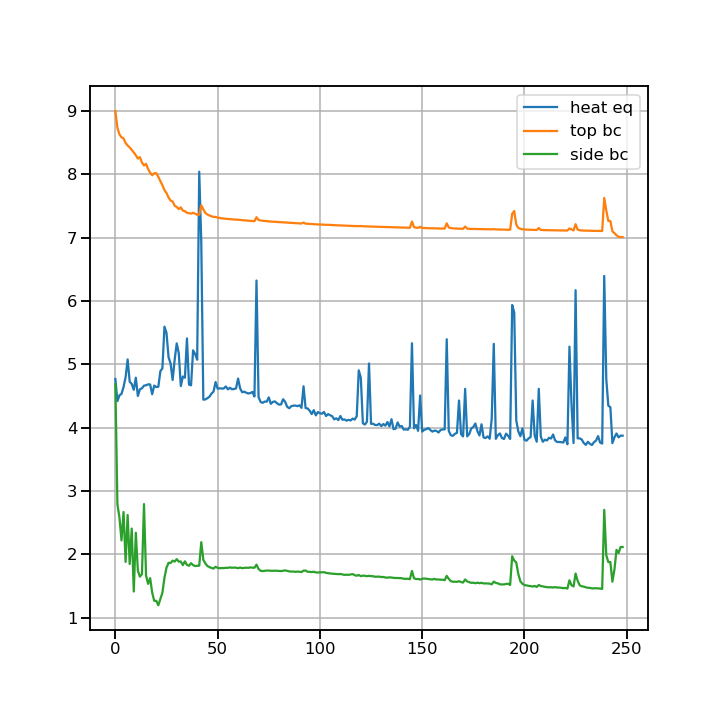

In [28]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 2
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(np.log(loss[n:]), label = name)

plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


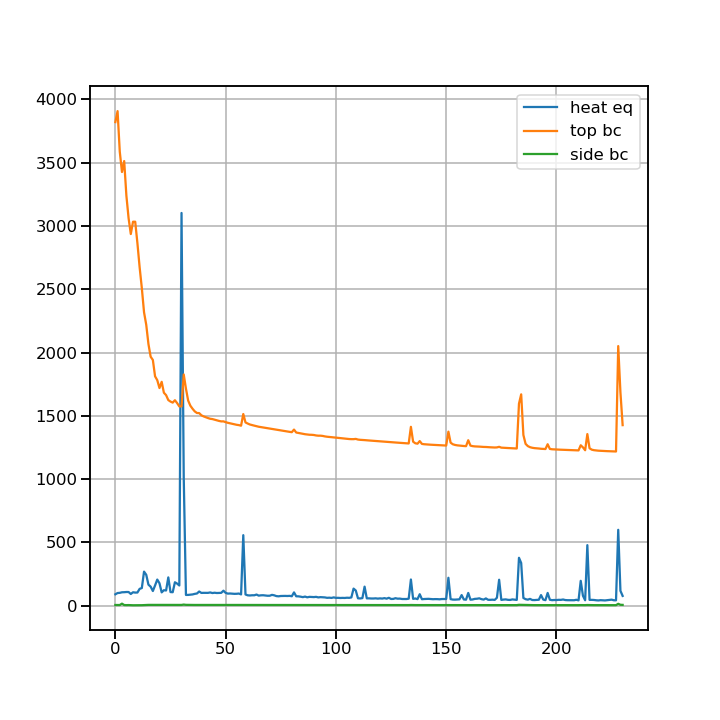

In [21]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 13
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


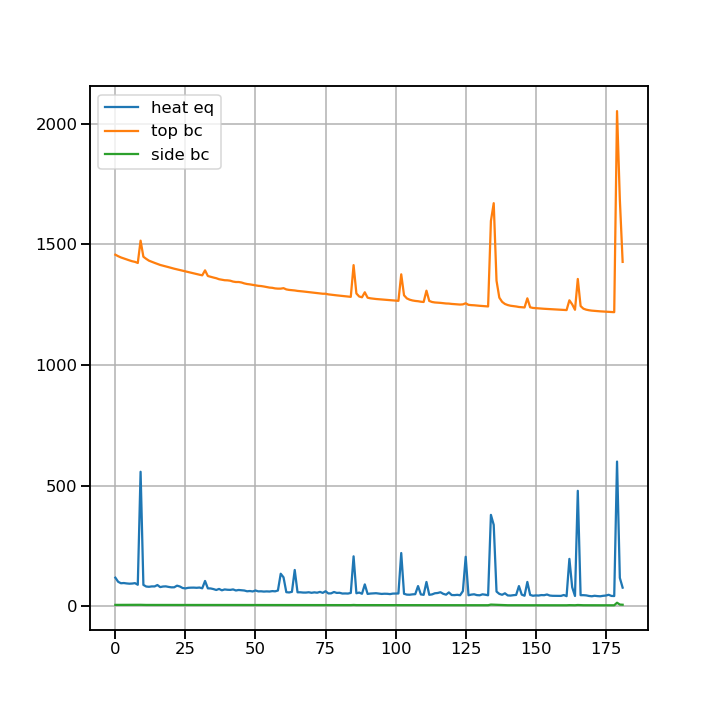

In [22]:
loss_names = ['heat eq', 'top bc', 'side bc', 'initial condition']
n = 62
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

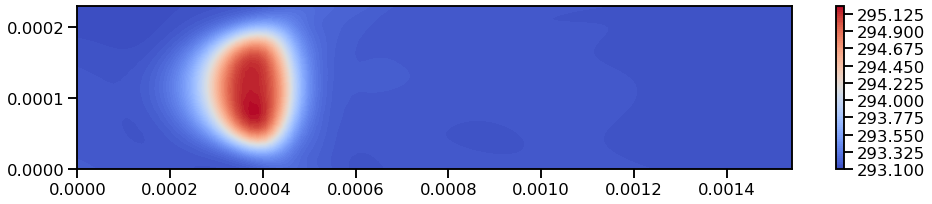

In [11]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0.001*t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

<IPython.core.display.Javascript object>


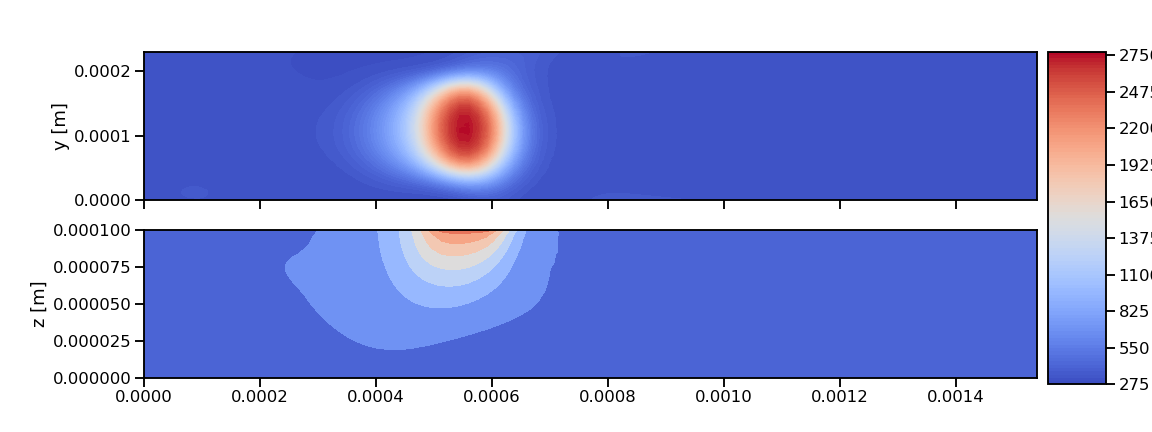

In [30]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 6), sharex=True)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
z_lin = np.linspace(0, z_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y [m]')
#plt.colorbar(CS, ax = ax1)

xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
Y2 = model.predict(X2)

xi2 = np.linspace(xx2.min(), xx2.max(), 100)
zi2 = np.linspace(zz2.min(), zz2.max(), 100)
data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm)
ax2.set_ylabel('z [m]')
#plt.colorbar(CS2, ax = ax2)

cbar_ax = fig.add_axes([0.91, 0.11, 0.05, 0.77])
fig.colorbar(CS, cax=cbar_ax)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
    
    xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [i/100*t_max])
    X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
    Y2 = model.predict(X2)

    xi2 = np.linspace(xx2.min(), xx2.max(), 100)
    zi2 = np.linspace(zz2.min(), zz2.max(), 100)
    data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

    CS2 = ax2.contourf(xi2, zi2, data2, intervall = 100, cmap=plt.cm.coolwarm)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

In [ ]:
slice_data = np.genfromtxt('of_phase/slice1/slice_124.csv', delimiter = ',',skip_header = True)

x = slice_data[:,0]
y = slice_data[:,1]
z = slice_data[:,2]
T = slice_data[:,3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

def animate(i):
    
    slice_data = np.genfromtxt('of_phase/slice1/slice_{}.csv'.format(i), delimiter = ',',skip_header = True)
    T = slice_data[:,3]
    
    #xx, yy, zz, tt = np.meshgrid(x, y, [z.max], [(i+1)/125*t_max])
    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max/125*(i+1))).T
    Y = model.predict(X)
    
    Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
    CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
anim = FuncAnimation(fig, animate, frames = 125, interval = 300)
from matplotlib.animation import FFMpegWriter

writervideo = FFMpegWriter(fps=60)
anim.save('pictures/video.mp4', writer=writervideo)

In [51]:
end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)

In [52]:
end_data

array([[2.5667e-05, 0.0000e+00, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03],
       [0.0000e+00, 0.0000e+00, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03],
       [2.5667e-05, 6.5714e-06, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03],
       ...,
       [1.4887e-03, 2.3000e-04, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03],
       [1.5143e-03, 2.3000e-04, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03],
       [1.5400e-03, 2.3000e-04, 1.0000e-04, ..., 0.0000e+00, 0.0000e+00,
        4.6800e+03]])

In [53]:
end_data.T[3]

array([293.16, 293.15, 293.2 , ..., 293.15, 293.15, 293.15])

In [57]:
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

Text(0, 0.5, 'T[K]')

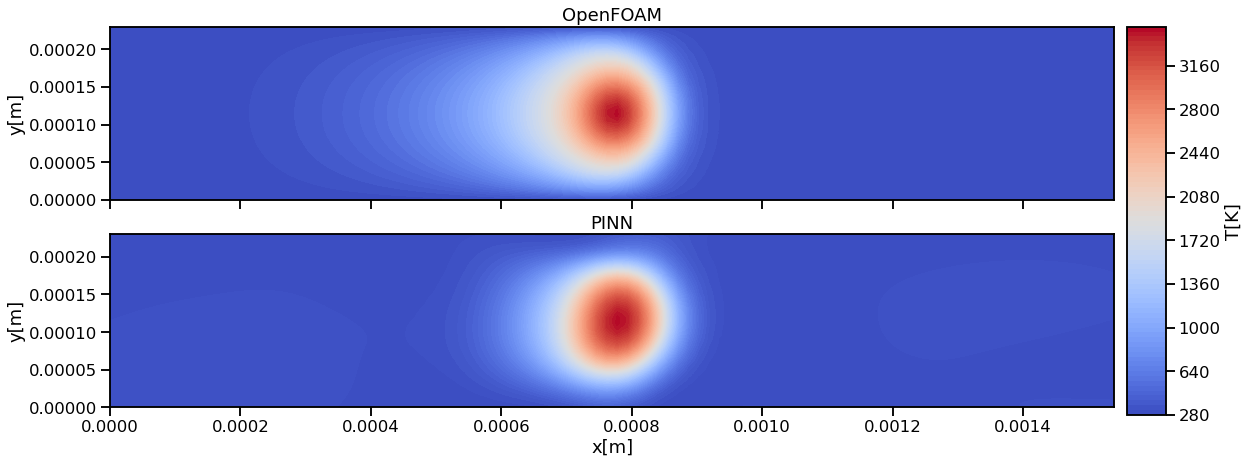

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm)

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

Text(0, 0.5, 'T[K]')

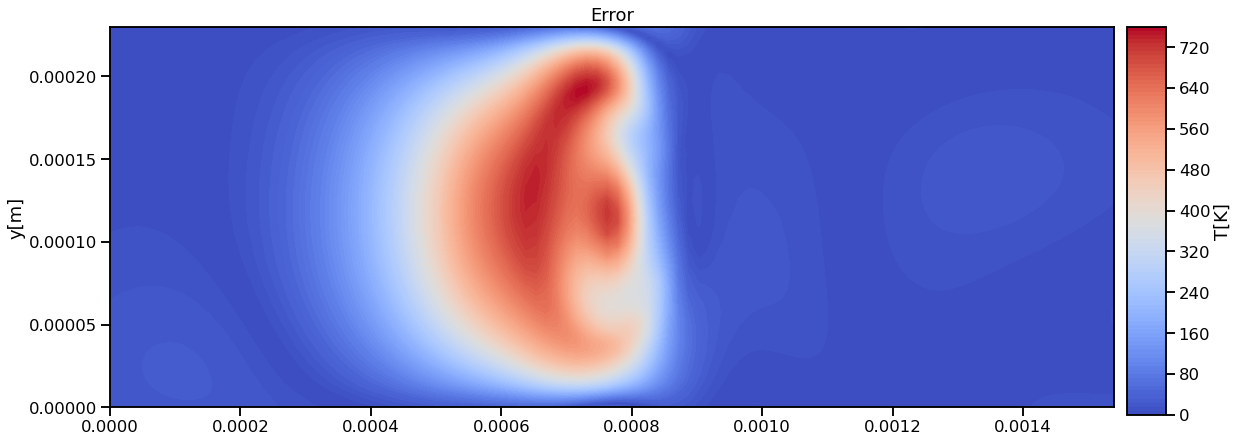

In [65]:
fig, (ax1) = plt.subplots(ncols = 1, nrows = 1, figsize = (18, 7))

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('Error')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, np.abs(Ti - T_pred), 100, cmap=plt.cm.coolwarm)

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

In [56]:
z.max()

0.00154

In [42]:
x.max()

0.0001

In [43]:
y.max()

0.00023

In [44]:
x_max

0.00154

In [45]:
y_max

0.00023

In [46]:
z_max

0.0001

In [61]:
T.max()

3447.3